# **Library**

In [ ]:
!pip install nltk
!pip install gensim
!pip install pyLDAvis
!pip install Wordcloud
!pip install vaderSentiment

# **Import Package**

In [ ]:
import pandas as pd
import numpy as np
import spacy
import gensim
import nltk
import matplotlib.pyplot as plt
import pyLDAvis.gensim
import re
from tqdm import tqdm
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from gensim.models.phrases import Phrases
from nltk.corpus import wordnet
from nltk import SnowballStemmer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from google.colab import drive

# Data Visualization
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline


# **Donwload NLTK**

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# **Dataset**

In [5]:
# Mount Google Drive
drive.mount('/content/drive/')
# Load the dataset
path = '/content/drive/MyDrive/Colab Notebooks/Resha Ananda Rahman (ABSA)/Data Gojek/gojek_data.csv'
data = pd.read_csv(path)
# Menampilkan beberapa baris data pertama
data.head()

Mounted at /content/drive/


,Unnamed: 0,userName,content,score,at
0,0,Doddy Wahyuwono,"Hi dev and product team, please remove the ani...",2,12/15/2023 16:12
1,1,Elda Mahaindra,"Hi, developer, could you please remove the ani...",5,10/22/2023 5:51
2,2,frecklixx_,It is too slow to open and process the app. I ...,2,9/12/2023 2:24
3,3,Yohana Sitanggang,It crashed a lot. I ended up causing a driver ...,2,10/15/2023 14:08
4,4,リン赤沢,"I'm absolutely furious with this statement. ""N...",1,11/7/2023 10:06


In [ ]:
data = data[['content']]
data.head()

,content
0,"Hi dev and product team, please remove the ani..."
1,"Hi, developer, could you please remove the ani..."
2,It is too slow to open and process the app. I ...
3,It crashed a lot. I ended up causing a driver ...
4,"I'm absolutely furious with this statement. ""N..."


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14147 entries, 0 to 14146
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  14147 non-null  object
dtypes: object(1)
memory usage: 110.6+ KB


# **Preprocessing**

## Data Cleaning

In [ ]:
def clean_text(content):
    if isinstance(content, str):
        # Menghapus spasi berlebihan
        content = re.sub(r'\s+', ' ', content)

        # Menghapus emoji
        content = re.sub(r':[^:]+:', '', content)

        # Menghapus hashtag
        content = re.sub(r'#\w+', '', content)

        # Menghapus mention
        content = re.sub(r'@[A-Za-z0-9]+', '', content)

        # Menghapus URL
        content = re.sub(r'https?://[A-Za-z0-9./]+', '', content)

        # Menghapus karakter selain huruf dan spasi
        content = re.sub(r'[^A-Za-z\s]', '', content)

        # Menghapus tanggal, angka, dan datetime
        content = re.sub(r'\b\d{1,2}[-/.]\d{1,2}[-/.]\d{2,4}\b', '', content)  # Menghapus tanggal
        content = re.sub(r'\b\d+\b', '', content)  # Menghapus angka
        content = re.sub(r'\b\d{1,2}:\d{1,2}(:\d{1,2})?\b', '', content)  # Menghapus format waktu

        # Menghilangkan tanda baca tambahan
        content = re.sub(r'[^\w\s]', '', content)

        return content.strip()
    else:
        return ""

# Contoh penggunaan pada DataFrame
tqdm.pandas()
data['clean_content'] = data['content'].progress_apply(lambda x: clean_text(x))

# Menghapus data kosong setelah proses pembersihan
data.dropna(subset=['clean_content'], inplace=True)
data.head()



100%|██████████| 14147/14147 [00:01<00:00, 11628.73it/s]


,content,clean_content
0,"Hi dev and product team, please remove the ani...",Hi dev and product team please remove the anim...
1,"Hi, developer, could you please remove the ani...",Hi developer could you please remove the anima...
2,It is too slow to open and process the app. I ...,It is too slow to open and process the app I f...
3,It crashed a lot. I ended up causing a driver ...,It crashed a lot I ended up causing a driver w...
4,"I'm absolutely furious with this statement. ""N...",Im absolutely furious with this statement No i...


## Case Folding

In [ ]:
# Fungsi untuk membuat teks menjadi huruf kecil
def lowercase_text(content):
    if isinstance(content, str):
        return content.lower()
    else:
        return ""

tqdm.pandas()
data['lower_content'] = data['clean_content'].progress_apply(lambda x: lowercase_text(x))

# Menghapus data kosong setelah proses pembersihan
data.dropna(subset=['lower_content'], inplace=True)
data.head()

100%|██████████| 14147/14147 [00:00<00:00, 344640.87it/s]


,content,clean_content,lower_content
0,"Hi dev and product team, please remove the ani...",Hi dev and product team please remove the anim...,hi dev and product team please remove the anim...
1,"Hi, developer, could you please remove the ani...",Hi developer could you please remove the anima...,hi developer could you please remove the anima...
2,It is too slow to open and process the app. I ...,It is too slow to open and process the app I f...,it is too slow to open and process the app i f...
3,It crashed a lot. I ended up causing a driver ...,It crashed a lot I ended up causing a driver w...,it crashed a lot i ended up causing a driver w...
4,"I'm absolutely furious with this statement. ""N...",Im absolutely furious with this statement No i...,im absolutely furious with this statement no i...


## Tokenizing

In [ ]:
# Load the English language model for spaCy
nlp = spacy.load("en_core_web_sm")

# Define a concise tokenize function using lambda
tokenize_text = lambda text: [token.text for token in nlp(text)]

# Apply tokenization with tqdm for progress monitoring
tqdm.pandas()
data['tokens_content'] = data['lower_content'].progress_apply(tokenize_text)

# Menghapus data kosong setelah proses pembersihan
data.dropna(subset=['tokens_content'], inplace=True)
data.head()

100%|██████████| 14147/14147 [03:28<00:00, 67.88it/s] 


,content,clean_content,lower_content,tokens_content
0,"Hi dev and product team, please remove the ani...",Hi dev and product team please remove the anim...,hi dev and product team please remove the anim...,"[hi, dev, and, product, team, please, remove, ..."
1,"Hi, developer, could you please remove the ani...",Hi developer could you please remove the anima...,hi developer could you please remove the anima...,"[hi, developer, could, you, please, remove, th..."
2,It is too slow to open and process the app. I ...,It is too slow to open and process the app I f...,it is too slow to open and process the app i f...,"[it, is, too, slow, to, open, and, process, th..."
3,It crashed a lot. I ended up causing a driver ...,It crashed a lot I ended up causing a driver w...,it crashed a lot i ended up causing a driver w...,"[it, crashed, a, lot, i, ended, up, causing, a..."
4,"I'm absolutely furious with this statement. ""N...",Im absolutely furious with this statement No i...,im absolutely furious with this statement no i...,"[i, m, absolutely, furious, with, this, statem..."


## Stopword

In [ ]:
stop_words = set(stopwords.words("english"))
stop_words.update(['i','hi', 'im', 'ive', 'go', 'pp', 'jek',
                   'monthsthis', 'busyomgfor', 'ojek', 'appit', 'youve',
                   'gonna', 'wanna', 'gotta', 'kinda', 'dunno', 'lemme'])

def remove_stopwords(tokens):
  return [token for token in tokens if token not in stop_words]

tqdm.pandas()
data['stopwords_content'] = data['tokens_content'].progress_apply(remove_stopwords)

# Menghapus data kosong setelah proses pembersihan
data.dropna(subset=['stopwords_content'], inplace=True)
data.head()

100%|██████████| 14147/14147 [00:00<00:00, 201447.00it/s]


,content,clean_content,lower_content,tokens_content,stopwords_content
0,"Hi dev and product team, please remove the ani...",Hi dev and product team please remove the anim...,hi dev and product team please remove the anim...,"[hi, dev, and, product, team, please, remove, ...","[dev, product, team, please, remove, animation..."
1,"Hi, developer, could you please remove the ani...",Hi developer could you please remove the anima...,hi developer could you please remove the anima...,"[hi, developer, could, you, please, remove, th...","[developer, could, please, remove, animations,..."
2,It is too slow to open and process the app. I ...,It is too slow to open and process the app I f...,it is too slow to open and process the app i f...,"[it, is, too, slow, to, open, and, process, th...","[slow, open, process, app, face, errors, recen..."
3,It crashed a lot. I ended up causing a driver ...,It crashed a lot I ended up causing a driver w...,it crashed a lot i ended up causing a driver w...,"[it, crashed, a, lot, i, ended, up, causing, a...","[crashed, lot, ended, causing, driver, waiting..."
4,"I'm absolutely furious with this statement. ""N...",Im absolutely furious with this statement No i...,im absolutely furious with this statement no i...,"[i, m, absolutely, furious, with, this, statem...","[absolutely, furious, statement, internet, con..."


## Lemmatization Data

In [ ]:
# Load model 'en_core_web_sm' from spaCy and disable parser and NER components
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Define lemmatization function
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in tqdm(texts, desc="Lemmatizing"):
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Perform lemmatization with tqdm for progress monitoring
tqdm.pandas()
lemmatized_content = lemmatization(data['stopwords_content'], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Update DataFrame with lemmatized content
data['lemmatized_content'] = lemmatized_content
data.dropna(subset=['lemmatized_content'], inplace=True)

# Menggabungkan kata-kata unigram menjadi satu teks utuh
data['ulasan'] = data['lemmatized_content'].apply(lambda x: ' '.join(x))
data.dropna(subset=['ulasan'], inplace=True)
data.head()

Lemmatizing: 100%|██████████| 14147/14147 [01:12<00:00, 193.83it/s]


,content,clean_content,lower_content,tokens_content,stopwords_content,lemmatized_content,ulasan
0,"Hi dev and product team, please remove the ani...",Hi dev and product team please remove the anim...,hi dev and product team please remove the anim...,"[hi, dev, and, product, team, please, remove, ...","[dev, product, team, please, remove, animation...","[dev, product, team, remove, animation, order,...",dev product team remove animation order food s...
1,"Hi, developer, could you please remove the ani...",Hi developer could you please remove the anima...,hi developer could you please remove the anima...,"[hi, developer, could, you, please, remove, th...","[developer, could, please, remove, animations,...","[developer, remove, animation, prepare, pack, ...",developer remove animation prepare pack food i...
2,It is too slow to open and process the app. I ...,It is too slow to open and process the app I f...,it is too slow to open and process the app i f...,"[it, is, too, slow, to, open, and, process, th...","[slow, open, process, app, face, errors, recen...","[slow, open, process, app, face, error, recent...",slow open process app face error recently want...
3,It crashed a lot. I ended up causing a driver ...,It crashed a lot I ended up causing a driver w...,it crashed a lot i ended up causing a driver w...,"[it, crashed, a, lot, i, ended, up, causing, a...","[crashed, lot, ended, causing, driver, waiting...","[crash, lot, end, cause, driver, wait, long, t...",crash lot end cause driver wait long time door...
4,"I'm absolutely furious with this statement. ""N...",Im absolutely furious with this statement No i...,im absolutely furious with this statement no i...,"[i, m, absolutely, furious, with, this, statem...","[absolutely, furious, statement, internet, con...","[absolutely, furious, statement, internet, con...",absolutely furious statement internet connecti...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14147 entries, 0 to 14146
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   content             14147 non-null  object
 1   clean_content       14147 non-null  object
 2   lower_content       14147 non-null  object
 3   tokens_content      14147 non-null  object
 4   stopwords_content   14147 non-null  object
 5   lemmatized_content  14147 non-null  object
 6   ulasan              14147 non-null  object
dtypes: object(7)
memory usage: 773.8+ KB


In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Resha Ananda Rahman (ABSA)/Data Gojek/preprocessing_data_gojek.csv'
data.to_csv(path, index=False)

# **Pemodelan Topic / Aspek**


In [ ]:
# Baca file CSV dari Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/Resha Ananda Rahman (ABSA)/Data Gojek/preprocessing_data_gojek.csv'
data = pd.read_csv(path)

# Hapus baris yang memiliki nilai NaN di kolom 'ulasan'
# data = data.dropna(subset=['ulasan'])

# Ubah tipe data kolom 'ulasan' menjadi string
data['ulasan'] = data['ulasan'].astype(str)

# Split setiap ulasan menjadi daftar kata
lemmatized_content = [text.split() for text in data['ulasan']]

## Bag Of Words

In [ ]:
# Membuat kamus (dictionary)
id2word = corpora.Dictionary(lemmatized_content)

# Membuat Corpus
corpus = lemmatized_content

# Term document frequency dari corpus
bow_corpus = [id2word.doc2bow(text) for text in corpus]

# View
print(corpus[:1])
print(bow_corpus[:1])
id2word[0]

[['dev', 'product', 'team', 'remove', 'animation', 'order', 'food', 'support', 'functionality', 'rather', 'directly', 'display', 'old', 'realtime', 'map', 'view', 'useful', 'ensure', 'location', 'correct', 'let', 'know', 'driver', 'location', 'style', 'substance']]
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1)]]


'animation'

## Model LDA

Num Topics = 2  has Coherence Value of 0.563
Num Topics = 3  has Coherence Value of 0.569
Num Topics = 4  has Coherence Value of 0.5


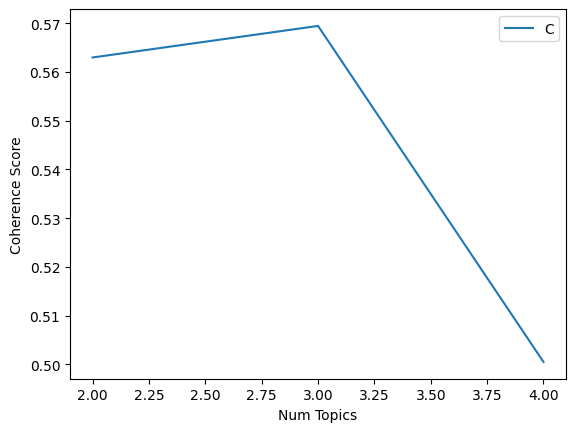

In [ ]:
# Fungsi untuk menghitung nilai coherence dari topic LDA
def compute_coherence_values(dictionary, bow_corpus, corpus, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                                num_topics=num_topics,
                                                id2word=id2word,
                                                random_state=100,
                                                update_every=1,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=corpus, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list, coherence_values

limit = 5
start = 2
step = 1
model_list, coherence_values = compute_coherence_values(id2word, bow_corpus, corpus, limit, start, step)

# Menampilkan grafik coherence score dan num topics
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(("Coherence Values"), loc='best')

# Menampilkan nilai koherensi untuk setiap jumlah topik
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 3))
plt.show()


## Visualisasi dan Interpretasi Topic

In [ ]:
# Choose the model with the highest coherence value
optimal_model_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[optimal_model_index]

# Visualize the topics of the optimal model
pyLDAvis.enable_notebook()
vis_topic = pyLDAvis.gensim.prepare(optimal_model, bow_corpus, id2word)
vis_topic


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.149674  0.214011       1        1  39.598953
0     -0.309323 -0.004552       2        1  37.790414
2      0.159649 -0.209459       3        1  22.610633, topic_info=        Term         Freq        Total Category  logprob  loglift
288     good  5872.000000  5872.000000  Default  30.0000  30.0000
42       app  4594.000000  4594.000000  Default  29.0000  29.0000
5     driver  2594.000000  2594.000000  Default  28.0000  28.0000
196  service  2055.000000  2055.000000  Default  27.0000  27.0000
208    great  1946.000000  1946.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
267  already   174.516939   183.740992   Topic3  -5.1849   1.4352
129      say   255.978728   361.325559   Topic3  -4.8018   1.1421
284   change   292.365813   543.295060   Topic3  -4.6689   0.8671
366    issue   204.321459   401.789476   Topic3  -5.0272   0.8105
134   always   201.604972   996.986500   Topic3  -5.0406  -0.1117

[138 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
324       1  0.002637  account
324       2  0.002637  account
324       3  0.994274  account
267       1  0.043540  already
267       2  0.005442  already
...     ...       ...      ...
176       2  0.002030     work
176       3  0.994912     work
243       1  0.994926    wrong
243       2  0.003305    wrong
243       3  0.003305    wrong

[318 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [ ]:
num_topics = optimal_model.num_topics

for topic_id in range(num_topics):
    print(f"Topik {topic_id + 1}:")
    topic_keywords = optimal_model.show_topic(topic_id, topn=20)
    print(', '.join([word for word, _ in topic_keywords]))
    print()


Topik 1:
good, app, service, great, gojek, use, easy, well, help, helpful, nan, thank, life, make, application, helpfull, nice, love, much, cool

Topik 2:
driver, get, order, bad, time, customer, always, cancel, star, find, give, food, far, ride, take, money, location, gofood, go, know

Topik 3:
gopay, crash, keep, top, update, work, still, account, close, fix, new, suck, email, bug, try, change, force, sere, say, payment



## Penentuan Dominan Aspek Per Kalimat

In [ ]:
def format_topics_sent(ldamodel, corpus, texts, data_lemmatized):
    sent_topics_list = []
    for i, row in enumerate(ldamodel[corpus]):
        topic_num, prop_topic = max(row[0], key=lambda x: x[1])
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join(word for word, prop in wp)
        sent_topics_list.append([int(topic_num), round(prop_topic, 3), topic_keywords, data_lemmatized[i]])

    data = pd.DataFrame(sent_topics_list, columns=['Dominant_topic', 'Perc_Contrib', 'Topic_Keywords', 'Data_Lemmatized'])
    data['Content'] = texts
    return data


# Path untuk file CSV di Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/Resha Ananda Rahman (ABSA)/Data Gojek/preprocessing_data_gojek.csv'

# Load data dari Google Drive
data = pd.read_csv(path)

lemmatized_content = data['lemmatized_content'].tolist()
texts = data['ulasan'].tolist()

# Now you can use the function with the loaded data
data = format_topics_sent(optimal_model, bow_corpus, texts, lemmatized_content)
data.head()


,Dominant_topic,Perc_Contrib,Topic_Keywords,Data_Lemmatized,Content
0,1,0.503,"driver, get, order, bad, time, customer, alway...","['dev', 'product', 'team', 'remove', 'animatio...",dev product team remove animation order food s...
1,1,0.691,"driver, get, order, bad, time, customer, alway...","['developer', 'remove', 'animation', 'prepare'...",developer remove animation prepare pack food i...
2,2,0.468,"gopay, crash, keep, top, update, work, still, ...","['slow', 'open', 'process', 'app', 'face', 'er...",slow open process app face error recently want...
3,1,0.498,"driver, get, order, bad, time, customer, alway...","['crash', 'lot', 'end', 'cause', 'driver', 'wa...",crash lot end cause driver wait long time door...
4,2,0.453,"gopay, crash, keep, top, update, work, still, ...","['absolutely', 'furious', 'statement', 'intern...",absolutely furious statement internet connecti...


In [ ]:
# Membuat dictionary untuk menghubungkan nilai Dominant_topic dengan aspek yang sesuai
aspect_mapping = {
    # aspect gojek
    0: 'User Experience',
    1: 'Service',
    2: 'Payment',

}

# Menggunakan dictionary untuk mengubah nilai Dominant_topic menjadi aspek yang sesuai
data['Aspect'] = data['Dominant_topic'].map(aspect_mapping)

# Display the updated DataFrame
data.head()

,Dominant_topic,Perc_Contrib,Topic_Keywords,Data_Lemmatized,Content,Aspect
0,1,0.503,"driver, get, order, bad, time, customer, alway...","['dev', 'product', 'team', 'remove', 'animatio...",dev product team remove animation order food s...,Service
1,1,0.691,"driver, get, order, bad, time, customer, alway...","['developer', 'remove', 'animation', 'prepare'...",developer remove animation prepare pack food i...,Service
2,2,0.468,"gopay, crash, keep, top, update, work, still, ...","['slow', 'open', 'process', 'app', 'face', 'er...",slow open process app face error recently want...,Payment
3,1,0.498,"driver, get, order, bad, time, customer, alway...","['crash', 'lot', 'end', 'cause', 'driver', 'wa...",crash lot end cause driver wait long time door...,Service
4,2,0.453,"gopay, crash, keep, top, update, work, still, ...","['absolutely', 'furious', 'statement', 'intern...",absolutely furious statement internet connecti...,Payment


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14147 entries, 0 to 14146
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Dominant_topic   14147 non-null  int64  
 1   Perc_Contrib     14147 non-null  float32
 2   Topic_Keywords   14147 non-null  object 
 3   Data_Lemmatized  14147 non-null  object 
 4   Content          14037 non-null  object 
 5   Aspect           14147 non-null  object 
dtypes: float32(1), int64(1), object(4)
memory usage: 608.0+ KB


In [ ]:
# Drop rows with empty values
data.dropna(inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14037 entries, 0 to 14146
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Dominant_topic   14037 non-null  int64  
 1   Perc_Contrib     14037 non-null  float32
 2   Topic_Keywords   14037 non-null  object 
 3   Data_Lemmatized  14037 non-null  object 
 4   Content          14037 non-null  object 
 5   Aspect           14037 non-null  object 
dtypes: float32(1), int64(1), object(4)
memory usage: 712.8+ KB


In [ ]:
# Simpan DataFrame ke dalam file CSV di Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/Resha Ananda Rahman (ABSA)/Data Gojek/label_aspek_gojek.csv'
data.to_csv(path, index=False)

# **Pelabelan Sentimen Vader**

In [ ]:
# Path untuk file CSV di Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/Resha Ananda Rahman (ABSA)/Data Gojek/label_aspek_gojek.csv'

# Load data dari Google Drive
vader = pd.read_csv(path)

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def sentiment_label_vader(text):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    compound_score = scores['compound']

    threshold_positive = 0.5  # Adjust these values as needed based on your data
    threshold_negative = -0.5

    if compound_score > threshold_positive:
        return 'Positive', compound_score
    elif compound_score < threshold_negative:
        return 'Negative', compound_score
    else:
        # Assign neutral sentiment to either positive or negative based on compound score
        if compound_score >= 0:
            return 'Positive', compound_score
        else:
            return 'Negative', compound_score

tqdm.pandas()
vader["Sentiment"], vader["Score"] = zip(*vader["Content"].progress_apply(sentiment_label_vader))

vader.head()


100%|██████████| 14037/14037 [03:13<00:00, 72.66it/s]


,Dominant_topic,Perc_Contrib,Topic_Keywords,Data_Lemmatized,Content,Aspect,Sentiment,Score
0,1,0.503,"driver, get, order, bad, time, customer, alway...","['dev', 'product', 'team', 'remove', 'animatio...",dev product team remove animation order food s...,Service,Positive,0.8020
1,1,0.691,"driver, get, order, bad, time, customer, alway...","['developer', 'remove', 'animation', 'prepare'...",developer remove animation prepare pack food i...,Service,Positive,0.5106
2,2,0.468,"gopay, crash, keep, top, update, work, still, ...","['slow', 'open', 'process', 'app', 'face', 'er...",slow open process app face error recently want...,Payment,Negative,-0.3818
3,1,0.498,"driver, get, order, bad, time, customer, alway...","['crash', 'lot', 'end', 'cause', 'driver', 'wa...",crash lot end cause driver wait long time door...,Service,Negative,-0.8271
4,2,0.453,"gopay, crash, keep, top, update, work, still, ...","['absolutely', 'furious', 'statement', 'intern...",absolutely furious statement internet connecti...,Payment,Negative,-0.5413


In [ ]:
# Simpan DataFrame ke dalam file CSV di Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/Resha Ananda Rahman (ABSA)/Data Gojek/label_sentiment_vader_gojek.csv'
vader.to_csv(path, index=False)

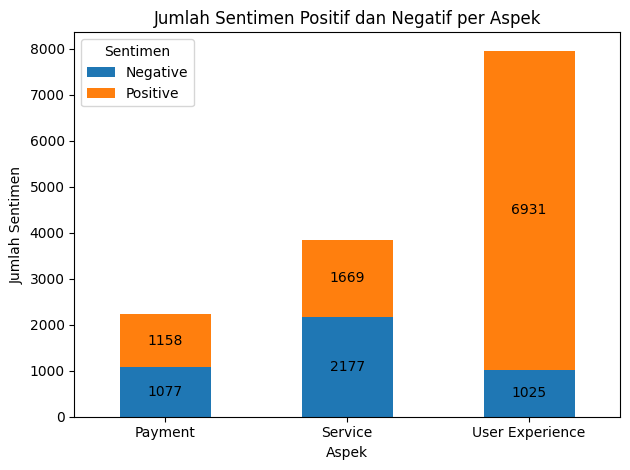

In [ ]:
import matplotlib.pyplot as plt

# Hitung jumlah sentimen positif dan negatif berdasarkan aspek
sentiment_counts_by_aspect = vader.groupby(['Aspect', 'Sentiment']).size().unstack(fill_value=0)

# Buat bar chart
ax = sentiment_counts_by_aspect.plot(kind='bar', stacked=True)
plt.title('Jumlah Sentimen Positif dan Negatif per Aspek')
plt.xlabel('Aspek')
plt.ylabel('Jumlah Sentimen')
plt.xticks(rotation=0)  # Rotasi label x agar lebih mudah dibaca
plt.legend(title='Sentimen')

# Tambahkan label nilai di tengah setiap bar
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_x(), p.get_y()
    ax.annotate(f"{int(height)}", (x + width / 2, y + height / 2), ha='center', va='center')

plt.tight_layout()  # Mengatur layout agar lebih rapi
plt.show()


In [ ]:
vader['Sentiment'].value_counts()

Sentiment
Positive    9758
Negative    4279
Name: count, dtype: int64

In [ ]:
vader['Aspect'].value_counts()

Aspect
User Experience    7956
Service            3846
Payment            2235
Name: count, dtype: int64

# **Pelabelan Sentimen Text Blob**

In [ ]:
# Path untuk file CSV di Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/Resha Ananda Rahman (ABSA)/Data Gojek/label_aspek_gojek.csv'

# Load data dari Google Drive
blob = pd.read_csv(path)

In [ ]:
from textblob import TextBlob

def sentiment_label_textblob(text):
    analysis = TextBlob(text)
    polarity_score = analysis.sentiment.polarity

    threshold_positive = 0.5  # Adjust these values as needed based on your data
    threshold_negative = -0.5

    if polarity_score > threshold_positive:
        return 'Positive', polarity_score
    elif polarity_score < threshold_negative:
        return 'Negative', polarity_score
    else:
        # Assign neutral sentiment to either positive or negative based on polarity score
        if polarity_score >= 0:
            return 'Positive', polarity_score
        else:
            return 'Negative', polarity_score

tqdm.pandas()
blob["Sentiment"], blob["Score"] = zip(*blob["Content"].progress_apply(sentiment_label_textblob))

blob.head()


100%|██████████| 14037/14037 [00:03<00:00, 4448.30it/s]


,Dominant_topic,Perc_Contrib,Topic_Keywords,Data_Lemmatized,Content,Aspect,Sentiment,Score
0,1,0.503,"driver, get, order, bad, time, customer, alway...","['dev', 'product', 'team', 'remove', 'animatio...",dev product team remove animation order food s...,Service,Positive,0.166667
1,1,0.691,"driver, get, order, bad, time, customer, alway...","['developer', 'remove', 'animation', 'prepare'...",developer remove animation prepare pack food i...,Service,Positive,0.000000
2,2,0.468,"gopay, crash, keep, top, update, work, still, ...","['slow', 'open', 'process', 'app', 'face', 'er...",slow open process app face error recently want...,Payment,Negative,-0.080519
3,1,0.498,"driver, get, order, bad, time, customer, alway...","['crash', 'lot', 'end', 'cause', 'driver', 'wa...",crash lot end cause driver wait long time door...,Service,Negative,-0.050000
4,2,0.453,"gopay, crash, keep, top, update, work, still, ...","['absolutely', 'furious', 'statement', 'intern...",absolutely furious statement internet connecti...,Payment,Positive,0.259184


In [ ]:
# Simpan DataFrame ke dalam file CSV di Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/Resha Ananda Rahman (ABSA)/Data Gojek/label_sentiment_blob_gojek.csv'
blob.to_csv(path, index=False)

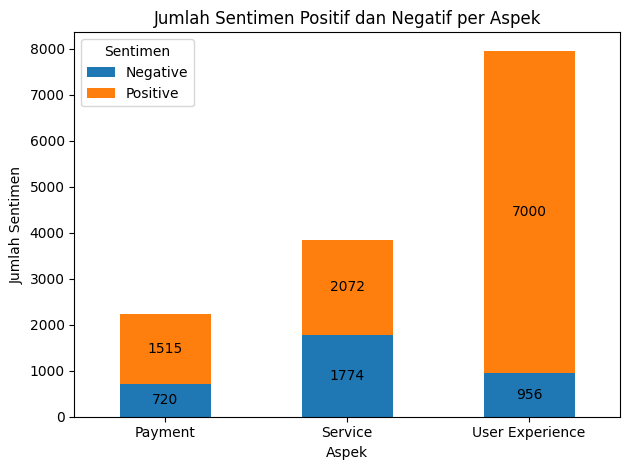

In [ ]:
import matplotlib.pyplot as plt

# Hitung jumlah sentimen positif dan negatif berdasarkan aspek
sentiment_counts_by_aspect = blob.groupby(['Aspect', 'Sentiment']).size().unstack(fill_value=0)

# Buat bar chart
ax = sentiment_counts_by_aspect.plot(kind='bar', stacked=True)
plt.title('Jumlah Sentimen Positif dan Negatif per Aspek')
plt.xlabel('Aspek')
plt.ylabel('Jumlah Sentimen')
plt.xticks(rotation=0)  # Rotasi label x agar lebih mudah dibaca
plt.legend(title='Sentimen')

# Tambahkan label nilai di tengah setiap bar
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_x(), p.get_y()
    ax.annotate(f"{int(height)}", (x + width / 2, y + height / 2), ha='center', va='center')

plt.tight_layout()  # Mengatur layout agar lebih rapi
plt.show()


In [ ]:
blob['Aspect'].value_counts()

Aspect
User Experience    7956
Service            3846
Payment            2235
Name: count, dtype: int64

In [ ]:
blob['Sentiment'].value_counts()

Sentiment
Positive    10587
Negative     3450
Name: count, dtype: int64

# **Pelabelan Sentimen BERT**

In [ ]:
# Path untuk file CSV di Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/Resha Ananda Rahman (ABSA)/Data Gojek/label_aspek_gojek.csv'

# Load data dari Google Drive
bert = pd.read_csv(path)

In [ ]:
# Import libraries
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load BERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased-finetuned-sst-2-english")

# Function to get sentiment using BERT model
def get_sentiment_bert(text):
    # Tokenize text
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    # Predict sentiment
    outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits, dim=1).item()
    score = torch.softmax(outputs.logits, dim=1)[0].tolist()  # Get softmax probabilities
    labels = ["Negative", "Positive"]  # Define labels
    return labels[predicted_class], score[predicted_class]

# Add "Sentiment" and "Score" columns to data
tqdm.pandas()  # Initialize tqdm on pandas
bert["Sentiment"], bert["Score"] = zip(*bert["Content"].progress_apply(get_sentiment_bert))

bert.head()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

100%|██████████| 14037/14037 [15:21<00:00, 15.23it/s]


,Dominant_topic,Perc_Contrib,Topic_Keywords,Data_Lemmatized,Content,Aspect,Sentiment,Score
0,1,0.503,"driver, get, order, bad, time, customer, alway...","['dev', 'product', 'team', 'remove', 'animatio...",dev product team remove animation order food s...,Service,Negative,0.998583
1,1,0.691,"driver, get, order, bad, time, customer, alway...","['developer', 'remove', 'animation', 'prepare'...",developer remove animation prepare pack food i...,Service,Negative,0.998168
2,2,0.468,"gopay, crash, keep, top, update, work, still, ...","['slow', 'open', 'process', 'app', 'face', 'er...",slow open process app face error recently want...,Payment,Negative,0.999373
3,1,0.498,"driver, get, order, bad, time, customer, alway...","['crash', 'lot', 'end', 'cause', 'driver', 'wa...",crash lot end cause driver wait long time door...,Service,Negative,0.996726
4,2,0.453,"gopay, crash, keep, top, update, work, still, ...","['absolutely', 'furious', 'statement', 'intern...",absolutely furious statement internet connecti...,Payment,Negative,0.995545


In [ ]:
# Simpan DataFrame ke dalam file CSV di Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/Resha Ananda Rahman (ABSA)/Data Gojek/label_sentiment_bert_gojek.csv'
bert.to_csv(path, index=False)

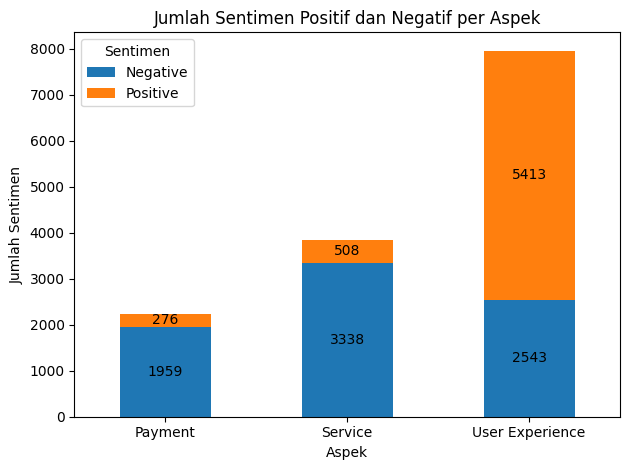

In [ ]:
import matplotlib.pyplot as plt

# Hitung jumlah sentimen positif dan negatif berdasarkan aspek
sentiment_counts_by_aspect = bert.groupby(['Aspect', 'Sentiment']).size().unstack(fill_value=0)

# Buat bar chart
ax = sentiment_counts_by_aspect.plot(kind='bar', stacked=True)
plt.title('Jumlah Sentimen Positif dan Negatif per Aspek')
plt.xlabel('Aspek')
plt.ylabel('Jumlah Sentimen')
plt.xticks(rotation=0)  # Rotasi label x agar lebih mudah dibaca
plt.legend(title='Sentimen')

# Tambahkan label nilai di tengah setiap bar
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_x(), p.get_y()
    ax.annotate(f"{int(height)}", (x + width / 2, y + height / 2), ha='center', va='center')

plt.tight_layout()  # Mengatur layout agar lebih rapi
plt.show()


In [ ]:
bert['Sentiment'].value_counts()

Sentiment
Negative    7840
Positive    6197
Name: count, dtype: int64

In [ ]:
bert['Aspect'].value_counts()

Aspect
User Experience    7956
Service            3846
Payment            2235
Name: count, dtype: int64

# Testing

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split


In [ ]:
data = pd.read_csv('label_sentiment_bert_gojek.csv')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['Content'], data['Sentiment'], test_size=0.15, random_state=42)


In [ ]:
jumlah_positif_latih = y_train.value_counts()[1]
jumlah_negatif_latih = y_train.value_counts()[0]
jumlah_positif_uji = y_test.value_counts()[1]
jumlah_negatif_uji = y_test.value_counts()[0]


In [ ]:
print('Data Latih:')
print('  Jumlah Positif:', jumlah_positif_latih)
print('  Jumlah Negatif:', jumlah_negatif_latih)

print('Data Uji:')
print('  Jumlah Positif:', jumlah_positif_uji)
print('  Jumlah Negatif:', jumlah_negatif_uji)


Data Latih:
  Jumlah Positif: 5261
  Jumlah Negatif: 6670
Data Uji:
  Jumlah Positif: 936
  Jumlah Negatif: 1170


# Visualisasi

In [ ]:
!pip install Wordcloud

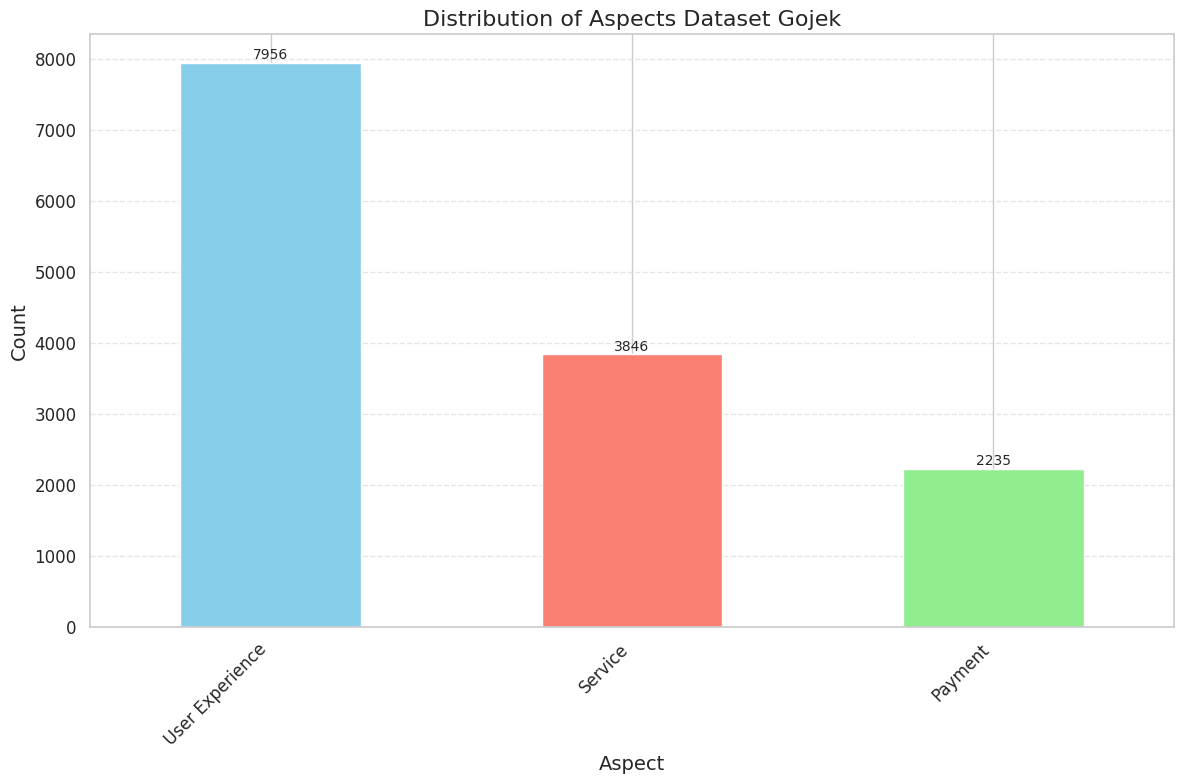

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Path untuk file CSV di Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/Resha Ananda Rahman (ABSA)/Data Gojek/label_aspek_gojek.csv'

# Load data dari Google Drive
data = pd.read_csv(path)

# Get value counts of 'Aspect'
aspect_counts = data['Aspect'].value_counts()

# Plotting the distribution
plt.figure(figsize=(12, 8))
aspect_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen', 'orange', 'lightcoral'])
plt.title('Distribution of Aspects Dataset Gojek', fontsize=16)
plt.xlabel('Aspect', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.gca().set_axisbelow(True)  # Ensure grid is behind the bars
for i, count in enumerate(aspect_counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

<ipython-input-6-96e2d64f1b8a>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


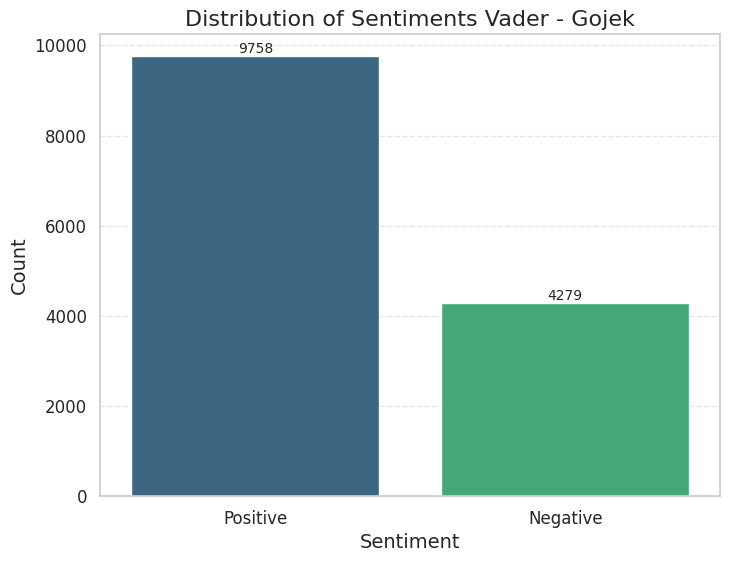

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Path untuk file CSV di Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/Resha Ananda Rahman (ABSA)/Data Gojek/label_sentiment_vader_gojek.csv'
# Load data dari Google Drive
data = pd.read_csv(path)

# Get value counts of 'Sentiment'
sentiment_counts = data['Sentiment'].value_counts()

# Set the style
sns.set(style="whitegrid")

# Plotting the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title('Distribution of Sentiments Vader - Gojek', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add count labels on top of each bar
for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)

plt.show()


<ipython-input-7-8616be3806fc>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


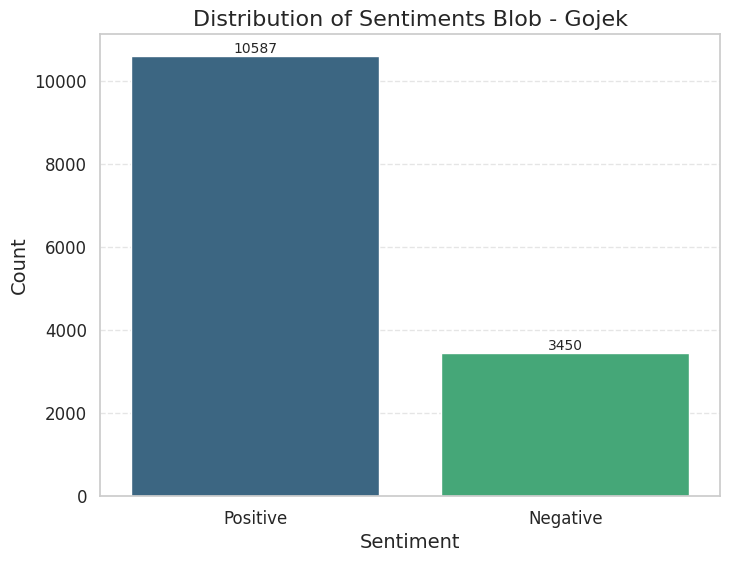

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Path untuk file CSV di Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/Resha Ananda Rahman (ABSA)n/Data Gojek/label_sentiment_blob_gojek.csv'
# Load data dari Google Drive
data = pd.read_csv(path)

# Get value counts of 'Sentiment'
sentiment_counts = data['Sentiment'].value_counts()

# Set the style
sns.set(style="whitegrid")

# Plotting the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title('Distribution of Sentiments Blob - Gojek', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add count labels on top of each bar
for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)

plt.show()


<ipython-input-8-cdf388305783>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


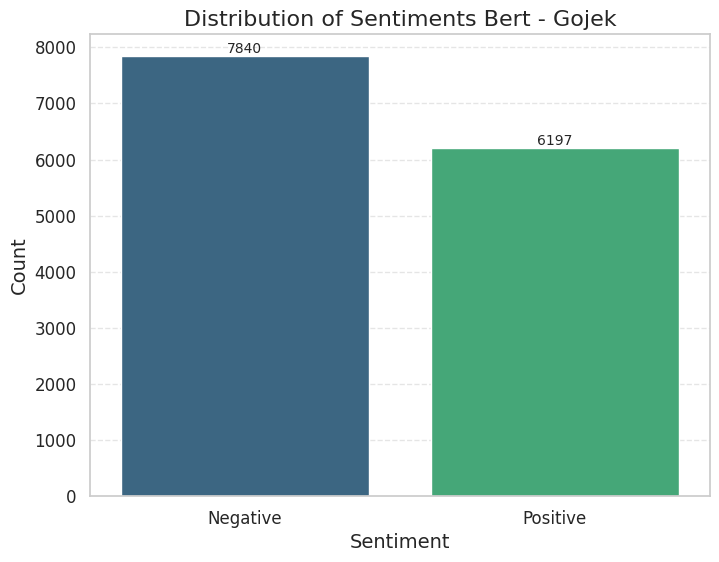

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Path untuk file CSV di Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/Resha Ananda Rahman (ABSA)/Data Gojek/label_sentiment_bert_gojek.csv'
# Load data dari Google Drive
data = pd.read_csv(path)

# Get value counts of 'Sentiment'
sentiment_counts = data['Sentiment'].value_counts()

# Set the style
sns.set(style="whitegrid")

# Plotting the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title('Distribution of Sentiments Bert - Gojek', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add count labels on top of each bar
for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)

plt.show()


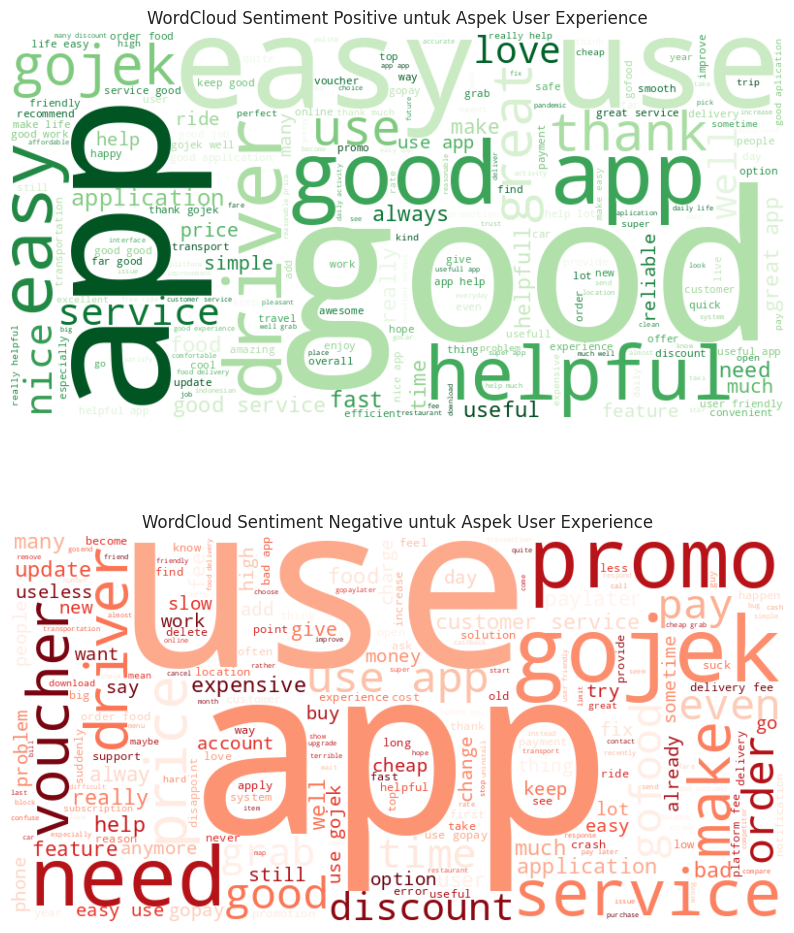

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Path untuk file CSV di Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/Resha Ananda Rahman (ABSA)/Data Gojek/label_sentiment_bert_gojek.csv'
# Load data dari Google Drive
data = pd.read_csv(path)

# Filter kata-kata dengan sentimen positif dan aspek User Experience
positive_words = ' '.join(data[(data['Sentiment'] == 'Positive') & (data['Aspect'] == 'User Experience')]['Content'])

# Filter kata-kata dengan sentimen negatif dan aspek User Experience
negative_words = ' '.join(data[(data['Sentiment'] == 'Negative') & (data['Aspect'] == 'User Experience')]['Content'])

# Buat objek WordCloud untuk sentimen positif dengan warna hijau
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_words)

# Buat objek WordCloud untuk sentimen negatif dengan warna merah
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_words)

# Tampilkan WordCloud untuk sentimen negatif
plt.figure(figsize=(10, 12))

plt.subplot(2, 1, 2)  # Subplot di baris pertama, posisi kolom pertama
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Sentiment Negative untuk Aspek User Experience')

# Tampilkan WordCloud untuk sentimen positif
plt.subplot(2, 1, 1)  # Subplot di baris kedua, posisi kolom pertama
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Sentiment Positive untuk Aspek User Experience')

plt.show()


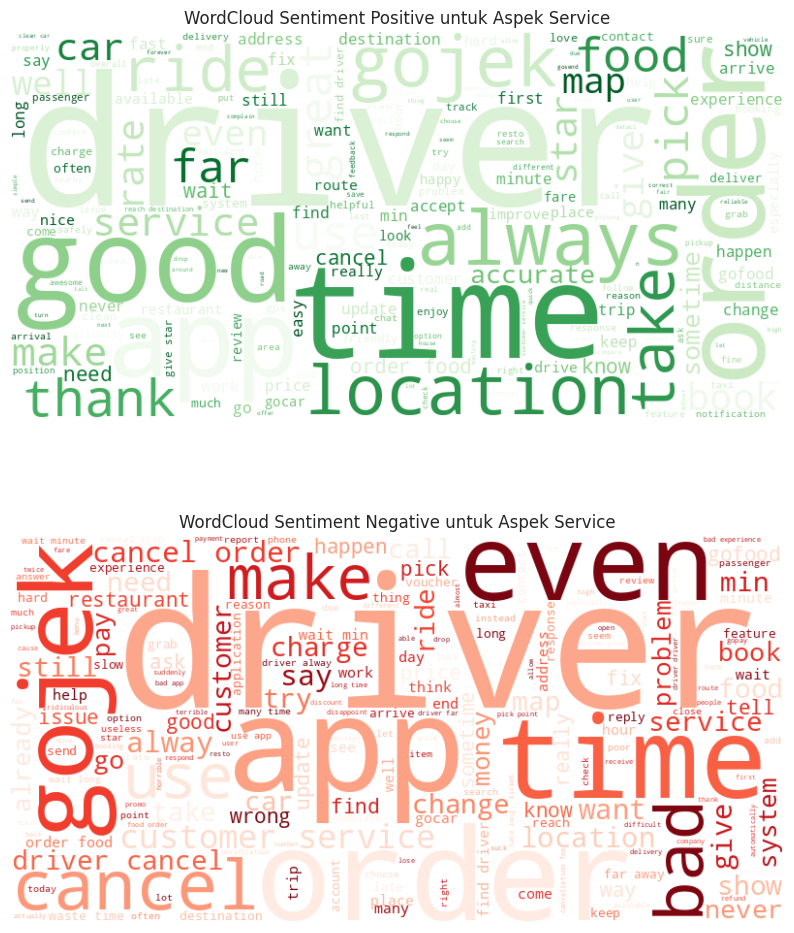

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Path untuk file CSV di Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/Resha Ananda Rahman (ABSA)/Data Gojek/label_sentiment_bert_gojek.csv'
# Load data dari Google Drive
data = pd.read_csv(path)

# Filter kata-kata dengan sentimen positif dan aspek User Experience
positive_words = ' '.join(data[(data['Sentiment'] == 'Positive') & (data['Aspect'] == 'Service')]['Content'])

# Filter kata-kata dengan sentimen negatif dan aspek Service
negative_words = ' '.join(data[(data['Sentiment'] == 'Negative') & (data['Aspect'] == 'Service')]['Content'])

# Buat objek WordCloud untuk sentimen positif dengan warna hijau
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_words)

# Buat objek WordCloud untuk sentimen negatif dengan warna merah
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_words)

# Tampilkan WordCloud untuk sentimen negatif
plt.figure(figsize=(10, 12))

plt.subplot(2, 1, 2)  # Subplot di baris pertama, posisi kolom pertama
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Sentiment Negative untuk Aspek Service')

# Tampilkan WordCloud untuk sentimen positif
plt.subplot(2, 1, 1)  # Subplot di baris kedua, posisi kolom pertama
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Sentiment Positive untuk Aspek Service')

plt.show()


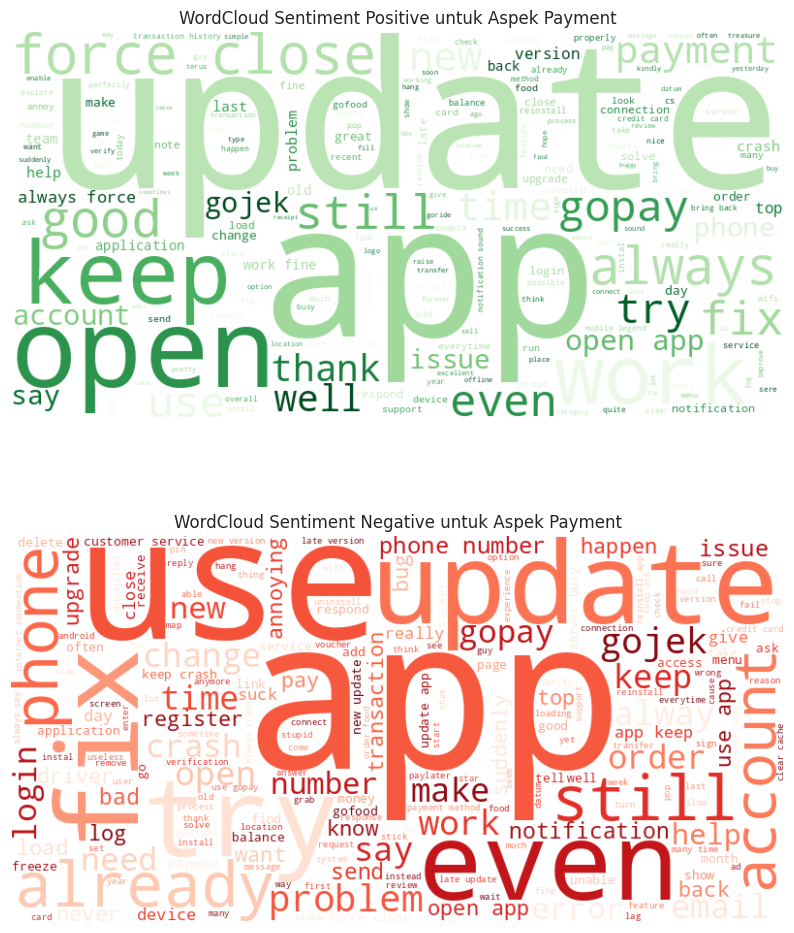

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Path untuk file CSV di Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/Resha Ananda Rahman (ABSA)/Data Gojek/label_sentiment_bert_gojek.csv'
# Load data dari Google Drive
data = pd.read_csv(path)

# Filter kata-kata dengan sentimen positif dan aspek Payment
positive_words = ' '.join(data[(data['Sentiment'] == 'Positive') & (data['Aspect'] == 'Payment')]['Content'])

# Filter kata-kata dengan sentimen negatif dan aspek Payment
negative_words = ' '.join(data[(data['Sentiment'] == 'Negative') & (data['Aspect'] == 'Payment')]['Content'])

# Buat objek WordCloud untuk sentimen positif dengan warna hijau
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_words)

# Buat objek WordCloud untuk sentimen negatif dengan warna merah
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_words)

# Tampilkan WordCloud untuk sentimen negatif
plt.figure(figsize=(10, 12))

plt.subplot(2, 1, 2)  # Subplot di baris pertama, posisi kolom pertama
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Sentiment Negative untuk Aspek Payment')

# Tampilkan WordCloud untuk sentimen positif
plt.subplot(2, 1, 1)  # Subplot di baris kedua, posisi kolom pertama
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud Sentiment Positive untuk Aspek Payment')

plt.show()


<ipython-input-31-bc2459f4f07b>:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


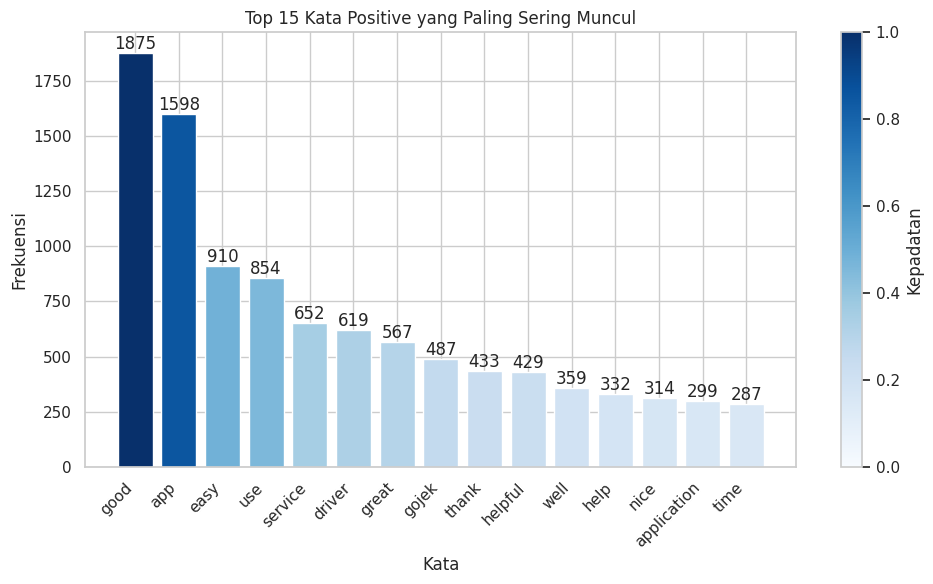

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

# Path untuk file CSV di Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/Resha Ananda Rahman (ABSA)/Data Gojek/label_sentiment_bert_gojek.csv'
# Load data dari Google Drive
data = pd.read_csv(path)

# Filter kata-kata dengan sentimen Positive
positive_words = data[data['Sentiment'] == 'Positive']['Content']

# Menggabungkan semua kata Positive menjadi satu teks
all_positive_words = ' '.join(positive_words)

# Memisahkan teks menjadi kata-kata
words_list = all_positive_words.split()

# Menghitung frekuensi kemunculan setiap kata
word_freq = pd.Series(words_list).value_counts()

# Mengambil 20 kata yang paling sering muncul
top_15_positive_words = word_freq.head(15)

# Plot grafik bar dengan colormap 'Blues'
plt.figure(figsize=(10, 6))
bars = plt.bar(top_20_positive_words.index, top_20_positive_words, color=plt.cm.Blues(word_freq / float(max(word_freq))))
plt.title('Top 15 Kata Positive yang Paling Sering Muncul')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')

# Menambahkan label jumlah pasti di atas setiap batang
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{top_20_positive_words[i]}',
             va='bottom', ha='center')

# Menambahkan color bar
sm = ScalarMappable(cmap=plt.cm.Blues)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Kepadatan')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


<ipython-input-38-a6e3c26e66d2>:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


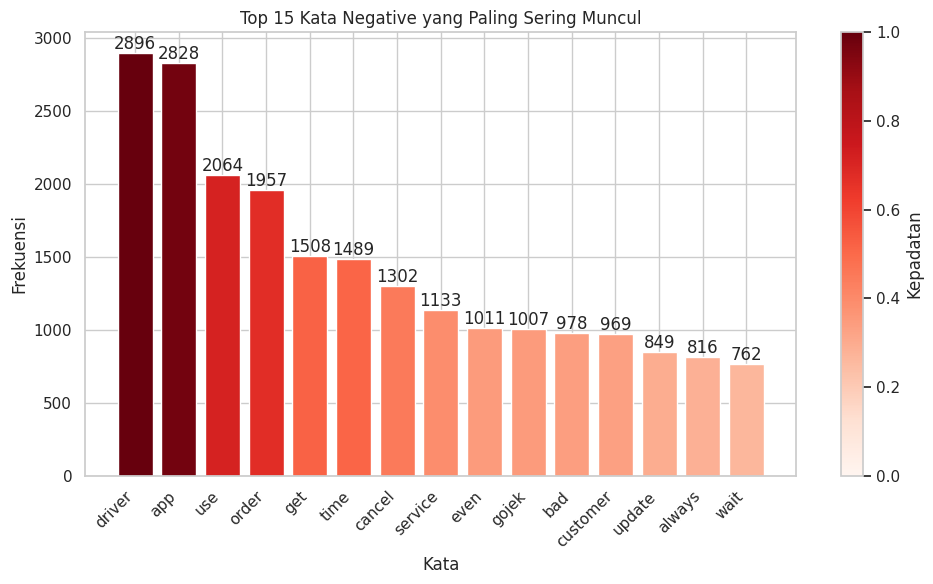

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

# Path untuk file CSV di Google Drive
path = '/content/drive/MyDrive/Colab Notebooks/Resha Ananda Rahman (ABSA)/Data Gojek/label_sentiment_bert_gojek.csv'
# Load data dari Google Drive
data = pd.read_csv(path)

# Filter kata-kata dengan sentimen Negative
negative_words = data[data['Sentiment'] == 'Negative']['Content']

# Menggabungkan semua kata Negative menjadi satu teks
all_negative_words = ' '.join(negative_words)

# Memisahkan teks menjadi kata-kata
words_list = all_negative_words.split()

# Menghitung frekuensi kemunculan setiap kata
word_freq = pd.Series(words_list).value_counts()

# Mengambil 20 kata yang paling sering muncul
top_15_negative_words = word_freq.head(15)

# Plot grafik bar dengan colormap 'Reds'
plt.figure(figsize=(10, 6))
bars = plt.bar(top_20_negative_words.index, top_20_negative_words, color=plt.cm.Reds(word_freq / float(max(word_freq))))
plt.title('Top 15 Kata Negative yang Paling Sering Muncul')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')

# Menambahkan label jumlah pasti di atas setiap batang
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{top_20_negative_words[i]}',
             va='bottom', ha='center')

# Menambahkan color bar
sm = ScalarMappable(cmap=plt.cm.Reds)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Kepadatan')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
